# Block-Silhouette Analysis for CogSci 2020

## Import and set up directories

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load Data

In [3]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [4]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

105 participants total


In [5]:
import analysis_helpers as h
importlib.reload(h)
Z = h.save_bis(df,csv_dir,iteration_name)

Saved BIS dataframe out!


In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['score'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'phase_extended',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
                  dodge=True,
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()


In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'gameID',
                y = 'rawF1DiscreteScore',
                #hue = 'phase',
                #hue = 'repetition',
                data = df)
plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Accuracy by participant\n',{'fontsize': 14})
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['rawF1DiscreteScore'],
                rug=True,
                kde=False)
plt.title('Distribution of Discrete F1 Scores\n',{'fontsize': 14})
plt.tight_layout()


In [ ]:
names = df.targetName.unique()
names.sort()
structure_numbers = list(map(lambda x: x[-2:],names))

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'targetName',
                y = 'rawF1DiscreteScore',
                order = names,
                data = df)
plt.ylabel('Mean Discrete Score')
plt.xlabel('Target ID')
plt.xticks(np.arange(len(names)),structure_numbers)
plt.title('Discrete F1 Scores by target\n',{'fontsize': 14})
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'targetNumber',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
            data = df)
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.tight_layout()

In [ ]:
# exclude outliers with low mean score
remove_outliers = False

if remove_outliers:

    threshold = 0.7

    df_means = df.groupby(by=['gameID'])['rawF1DiscreteScore'].apply(np.mean).reset_index()
    low_scores = df_means[df_means.rawF1DiscreteScore< threshold]['gameID'] 
    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score <'+str(threshold)+' and full set of trials')



In [ ]:
# Exclude outliers with low total bonus

remove_outliers = False

if remove_outliers:

    low_scores = df[(df.trialNum == (num_trials-1)) & (df.score == 0)]['gameID'] # people who achieved zero bonus


    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score > 0 and full set of trials')


In [ ]:
if False:
    importlib.reload(drawing)
    drawing.draw_all_trials(df, figsize=(20,80))

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()


In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(y='targetName', 
                x='trialNum', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.tight_layout()


In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='targetName', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Condition')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 2})
c = sns.pointplot(x='condition', 
                y='rawF1DiscreteScore', 
                hue='gameID', 
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(7,6))
sns.set_context('poster')
sns.set(font_scale=2)
sns.set(style='whitegrid', rc={"lines.linewidth": 4})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                #hue='condition',
                #style='condition',
                #style_order=['repeated','control'],
                #kind='point', 
                #legend=False,]
                #data=df[~df.blockFell]);
                #data=df[~df.blockFell]);
                data=df)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
c.set(xlabel='Phase', ylabel='F1 Score')
plt.yticks(np.linspace(0.7,0.9,5))
plt.ylim((0.7,0.9))
plt.tight_layout()

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,]
                #data=df[~df.blockFell]);
                #data=df[~df.blockFell]);
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(.4,1,5))
#plt.ylim((0.65,0.95))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
#Mean number of trials with blocks falling

df_block_fell_means = df.groupby(by=['gameID','phase_extended'])['blockFell'].agg(np.mean).reset_index()


#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.barplot(x='phase_extended', 
                y='blockFell', 
                order=['pre','repetition 1','repetition 2','post'],
                palette="ch:r=-.3,d=.1_r",
                data = df_block_fell_means)
c = sns.swarmplot(x='phase_extended', 
                    y='blockFell',
                    order=['pre','repetition 1','repetition 2','post'],
                    dodge=True,
                    palette="ch:r=-.3,d=.15_r",
                    data = df_block_fell_means)

In [ ]:
df_block_fell_means['blockFell'].value_counts()

### Exploration into why F1 seems higher for repeated

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='targetName',
                style='condition',
                ci = None,
                #style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df, col="targetNumber", col_wrap=4, height=4, hue="condition")
g.map(sns.lineplot, "phase_number", "rawF1DiscreteScore")

In [ ]:
# def target_plot(df, x=  **kwargs):
#     sns.lineplot(df, x=, **kwargs)

# g = sns.FacetGrid(tips, col="sex", height=4)
# g.map(quantile_plot, "total_bill");

df['targetNumber'] = df['targetName'].apply(lambda x: x[-2:])

sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df[(~df.blockFell) & (df.phase.isin(['pre']))], col="targetNumber", col_wrap=4, height=4, hue="condition")
#g.map(sns.lineplot, "phase", "rawF1DiscreteScore");
g.map(plt.hist, "rawF1DiscreteScore", density=True, bins=8, alpha=0.5)
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# Number of blocks

#df[df.condition=='control']['targetName'].value_counts()
df[df.condition=='repeated']['targetName'].value_counts()

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Trial')
#plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition',
                #kind='point', 
                #legend=False,
                data=df);

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set(style="ticks", rc={"lines.linewidth": 0.5})
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='trialNum', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.ylim(0.4,1)
plt.tight_layout()


In [ ]:
#double check that repeated condition isn't coming after control

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='condition', 
                y='trialNum', 
                #hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

In [ ]:
df_pre = df[df.phase=='pre']
df_grouped_pre = df_pre.groupby(by=['gameID','condition'])['rawF1DiscreteScore'].apply(np.mean).reset_index()

df_grouped_pre_wide = df_grouped_pre.pivot(index='gameID', columns='condition',values='rawF1DiscreteScore')


# Build Time over trials
fig = plt.figure(figsize=(10,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='control', 
                    y='repeated', 
                    #hue='repeated',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    #palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df_grouped_pre_wide)


In [ ]:
# Individual accuracy, pre- vs. post-

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)


In [ ]:
# Individual accuracy, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

## Number of blocks

In [ ]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                hue='condition',
                #style='condition',
                #style_order=['repeated','control'],
                #data=df[df.blockFell == False]);
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

In [ ]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                hue='blockFell',
                #style='condition',
                #style_order=['repeated','control'],
                #data=df[df.blockFell == False]);
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

In [ ]:
# Individual block use pre- and post- 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
# Individual block use, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

### Area covered

In [ ]:
# add area over time
world_maps = df['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
df['area_covered'] = world_maps.apply(np.sum)

In [ ]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
c = sns.lineplot(x='phase_number', 
                y='area_covered', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #data=df[df.blockFell == False]);
                data=df);
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

## Build Time

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='phase', 
                y='timeToBuild', 
                hue='perfectScore', 
                #kind='point', 
                #legend=False,
                data=df[df.phase.isin(['pre','post'])])
plt.ylabel('time to build (ms)')
plt.xlabel('Repetition')
plt.title('Build time by repetition (control repetition 1 happens at same time as repeated repetition 3)\n',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                y='jaccardDiscrete', 
                #hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('Jaccard')
plt.xlabel('rawF1DiscreteScore (new)')
plt.title('Jaccard vs. F1 score',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()


In [ ]:
# Build Time over phase

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  #hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[(df.phase.isin(['pre','post']))])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
# Individual block use pre- and post- 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df[df.phase.isin(['pre','post'])], col="targetNumber", col_wrap=4, height=4, hue="gameID")
g.map(sns.pointplot, "phase","buildTime");

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[~df.blockFell])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='condition',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(y='blockFell', 
                  x='phase_extended',
                  #kind='point', 
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [ ]:
#perfect scores over time

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.countplot(x='phase', hue='perfectScore', data = df)

In [ ]:
df_perfect_score_means = df.groupby(by=['gameID','phase'])['perfectScore'].agg(np.mean).reset_index()

#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.barplot(x='phase', 
                y='perfectScore', 
                order=['pre','repeated','post'],
                palette="ch:r=-.3,d=.1_r",
                data = df_perfect_score_means)
c = sns.swarmplot(x='phase', 
                    order=['pre','repeated','post'],
                    dodge=True,
                    y='perfectScore',
                    palette="ch:r=-.3,d=.15_r",
                    data = df_perfect_score_means)

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='perfectScore', 
                  hue='gameID',
                  order=['pre','repeated','post'],
                  legend=False,
                  dodge=True,
                  #kind='point', 
                  size = 0.3,
                  data=df_perfect_score_means)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [ ]:
df_perfect_score_means = df.groupby(by=['gameID','phase_extended'])['perfectScore'].agg(np.mean).reset_index()

#perfect scores over time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

c = sns.swarmplot(x='phase_extended', 
                    order=['pre','repetition 1','repetition 2','post'],
                    dodge=True,
                    y='perfectScore',
                    palette="ch:r=-.25,d=.15_r",
                    data = df_perfect_score_means)
c = sns.pointplot(x='phase_extended', 
                y='perfectScore', 
                order=['pre','repetition 1','repetition 2','post'],
                data = df_perfect_score_means)

In [ ]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df[~df.perfectScore]);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(.4,1,5))

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.0,1))

In [ ]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[(~df.perfectScore)&(~df.blockFell)])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
# Score by Build Time
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='buildTime', 
                    y='rawF1DiscreteScore', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='blockFell',
                    linewidth=0,
                    #kind='point',
                    alpha=0.5,
                    data=df)
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='timeToBuild', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='rawF1DiscreteScore',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df[df.timeToBuild>60000])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='timeToBuild', 
                    style='perfectScore',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    hue='rawF1DiscreteScore',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df[~df.blockFell])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='trialNum', 
                    y='rawF1DiscreteScore', 
                    style='blockFell',
                    #size= 'numBlocks',
                    #sizes=(10,30),
                    hue='phase_extended',
                    linewidth=0,
                    #kind='point',
                    alpha=0.7,
                    data=df)
                    #data=df[~df.blockFell])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

## Block Distributions

Here we calculate the probability distributions of using certain block kinds (that is blocks of a certain dimension)

A: 1x2, B: 2x1, C: 2x2, D: 2x4, E: 4x2

In [7]:
#Helper functions

def probs(data):
    nBlocks = np.sum(data['blockKind'].value_counts())
    sums = data['blockKind'].value_counts()
    probs = (sums/nBlocks).sort_index().reset_index()
    return probs

def prob_list(data):
    nBlocks = np.sum(data['blockKind'].value_counts())
    sums = data['blockKind'].value_counts()
    probs = (sums/nBlocks).sort_index()
    return probs

def block_kind_plot(**kwargs):
    data = kwargs.pop("data")
    sns.barplot(x='index', 
                y='blockKind',
                #hue='condition', 
                ci=False,
                #kind='point', 
                #legend=False,
                data=probs(data),
                **kwargs)
    
    
def block_counts(data):
    sums = data['blockKind'].value_counts()
    return sums

In [ ]:
prob_list()

### Visualize distributions of block kind

Note that we would expect some difference between pre and post.
People place more blocks.
It is likely they are reaching higher parts of the structures, which will require a different distribution of blocks from the lower end of the structures.


Before normalizing- see if pre is subsumed by post. Using same blockkind distribution plus final blocks

In [ ]:
ppts = np.sort(df['gameID'].unique())
targets = np.sort(df['targetName'].unique())

block_counts(dfs[(dfs.gameID==ppts[0])&(dfs.targetName==targets[0])&(dfs.phase=='pre')])

In [ ]:
#for each structure
#for each participant
#take pre and post
#do they get more peaky?

target_1 = np.zeros(len(ppts))



In [ ]:
# pre vs post
f = sns.FacetGrid(dfs[dfs.phase.isin(['pre','post'])], col="phase")
g = f.map_dataframe(block_kind_plot, palette="GnBu")

In [ ]:
# Compare overall change in blockKind distributions.

f = sns.FacetGrid(dfs, col="phase", row="condition")
g = f.map_dataframe(block_kind_plot, palette="GnBu").add_legend()


In [ ]:
#Compare pre and post for individual structures

f = sns.FacetGrid(dfs[dfs.phase.isin(['pre','post'])], row="targetName", col='phase')
g = f.map_dataframe(blockKindPlot, palette="GnBu")

## Quantify difference: Earth Mover's (Wasserstein) Distance

In [8]:
#Calculate Earth Mover's (Wasserstein) Distance between distributions of block kinds
#What is the difference pre and post?

pre_probs = prob_list(dfs[dfs.phase=='pre'])
post_probs = prob_list(dfs[dfs.phase=='post'])

stats.wasserstein_distance(pre_probs, post_probs)

0.012948114727682904

How does this compare to difference between participants, and difference between structures?

In [ ]:
#What are the difference in distribution across participants?
ppts = np.sort(df['gameID'].unique())
ppt_probs = [prob_list(dfs[dfs.gameID==ppt]) for ppt in ppts]

ppt_dists = np.zeros((len(ppts),len(ppts)))

for i, ppt1 in enumerate(ppt_probs):
    for j, ppt2 in  enumerate(ppt_probs):
        ppt_dists[i,j] = stats.wasserstein_distance(ppt1, ppt2)

        
fig, ax = plt.subplots()
ax.imshow(ppt_dists)

In [ ]:
#What are the difference in distribution across structure?

targets = np.sort(df['targetName'].unique())
target_probs = [prob_list(dfs[dfs.targetName==target]) for target in targets]

target_dists = np.zeros((len(targets),len(targets)))

for i, target1 in enumerate(target_probs):
    for j, target2 in  enumerate(target_probs):
        target_dists[i,j] = stats.wasserstein_distance(target1, target2)
       
fig, ax = plt.subplots()
ax.imshow(target_dists)

In [ ]:
t = np.tril(target_dists).flatten()
p = np.tril(ppt_dists).flatten()
t_filt = t[t>0] #is there a better way to do this that won't remove genuine zero-distance values
p_filt = p[p>0] #is there a better way to do this that won't remove genuine zero-distance values
sns.distplot(t_filt, kde=True)
sns.distplot(p_filt, kde=True)

In [ ]:
# Are participants converging on a small set of solutions?
# Is there less between-subject variation in post compared to pre?

targets = np.sort(df['targetName'].unique())

pre_target_probs = [prob_list(dfs[(dfs.phase=='pre') & (dfs.targetName==target)]) for target in targets]
pre_target_dists = np.zeros((len(targets),len(targets)))
for i, target1 in enumerate(pre_target_probs):
    for j, target2 in  enumerate(pre_target_probs):
        pre_target_dists[i,j] = stats.wasserstein_distance(target1, target2)
        
post_target_probs = [prob_list(dfs[(dfs.phase=='post') & (dfs.targetName==target)]) for target in targets]
post_target_dists = np.zeros((len(targets),len(targets)))
for i, target1 in enumerate(post_target_probs):
    for j, target2 in  enumerate(post_target_probs):
        post_target_dists[i,j] = stats.wasserstein_distance(target1, target2)


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(
ax.set_title('pre')
ax.imshow(pre_target_dists)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('post')
ax.imshow(post_target_dists)



In [ ]:
dfs.columns

The distance between pre and post (0.013) is pretty small compared to between participants, or between structures

## Spatial Distribution

hand_selected_006


Text(0.5, 1.0, 'post, repeated')

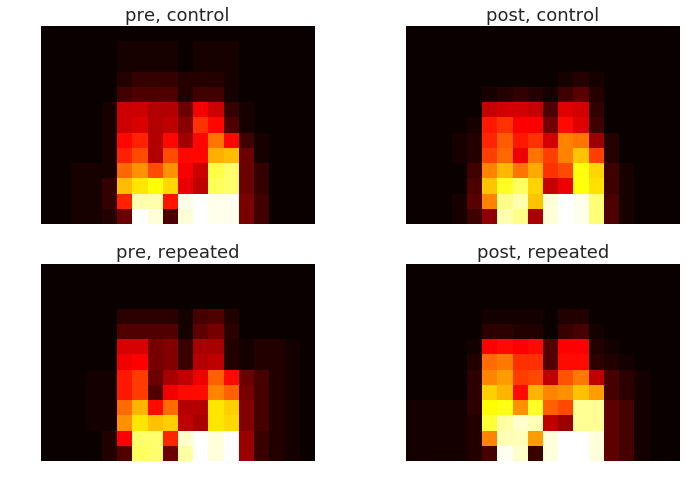

In [9]:
def showDiscreteMap(data, ax, vmax=None, **kwargs):
    world_maps = data.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
    n = world_maps.shape[0]
    av_map = np.add.reduce(np.array(world_maps))
    av_map = np.rot90(av_map)/n
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                **kwargs)
    else:
        ax.imshow(av_map,
                **kwargs)
    



targets = np.sort(df['targetName'].unique())
target= targets[2]
cmap= 'hot'

print(target)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2, 2, 1)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre') & (df.condition=='control')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('pre, control')

ax = fig.add_subplot(2, 2, 2)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='post') & (df.condition=='control')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('post, control')

ax = fig.add_subplot(2, 2, 3)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre') & (df.condition=='repeated')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('pre, repeated')

ax = fig.add_subplot(2, 2, 4)
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='post') & (df.condition=='repeated')]['discreteWorld'], ax, cmap=cmap)
ax.set_title('post, repeated')

#fig, ax = plt.subplots()
#showDiscreteMap(df[(df.targetName=='hand_selected_005') & (df.phase=='post')]['discreteWorld'], ax)

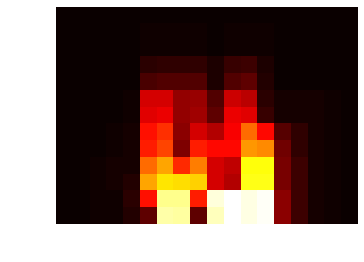

In [10]:
fig, ax = plt.subplots()
ax.axis('off')
showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld'], ax, cmap='hot')

In [11]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

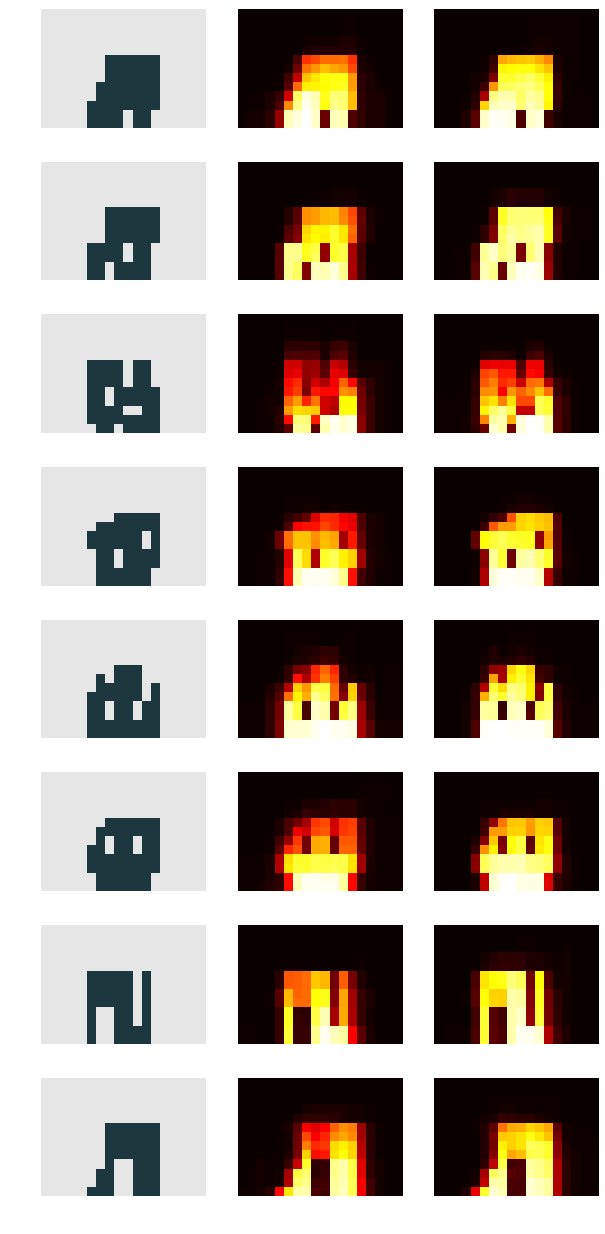

In [31]:
#Need to unnormalize these??

targets = np.sort(df['targetName'].unique())


fig = plt.figure(figsize=(10,22))
k=1

for i, target in enumerate(targets):
    
    cmap = colors.ListedColormap([[28/255,55/255,62/255],[230/255,230/255,230/255]])
    bounds=[0,1,50]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    silhouette = 1*(targetMaps[target])
    silhouette = np.rot90(silhouette)
    ax.imshow(silhouette, cmap=cmap, norm=norm)
    k+=1
    
    cmap= 'hot'
    bounds=[0,1]
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    
    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    showDiscreteMap(df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld'], ax, cmap=cmap, norm=norm)
    #ax.set_title(target + ': pre')
    k+=1

    ax = fig.add_subplot(len(targets), 3, k)
    ax.axis('off')
    showDiscreteMap(df[(df.targetName==target) & (df.phase=='post')]['discreteWorld'], ax, cmap=cmap, norm=norm)
    #ax.set_title(target + ': post')
    k+=1
    
#4, 6, 9, 11

[]

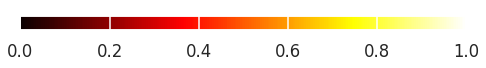

In [28]:
im = np.repeat([np.linspace(0,1,500)],repeats=50,axis=0)
fig, ax = plt.subplots(figsize=(8, 1))
#fig.subplots_adjust(bottom=0.5)
cmap = 'hot'
ax.imshow(im, cmap=cmap,extent=[0,1,0,0.033])
ax.set_yticks([])


In [32]:
fig.savefig('color_bar.pdf')

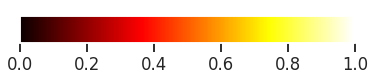

In [33]:
cmap = 'hot'
#norm = colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

#cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
fig.show()

In [34]:
from collections import deque 

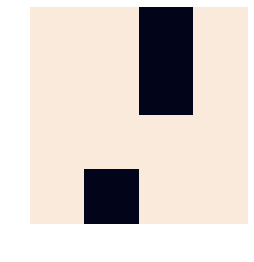

In [37]:
test = np.array([[100,100,0,100],[100,100,0,100],[100,100,100,100],[100,0,100,100]])
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(test)

In [39]:
def getBlockDists(mat, show_fig=False):
    n = mat.shape[0] 
    m = mat.shape[1]
    q = deque([])
    for i in range(0,n):
        for j in range(0,m):
            if mat[i,j] == 0:
                q.append((i,j,0))
    changed=True
    while (q):
        (i,j,v) = q.popleft()
        # check values around square
        #xs = [i-1,i,i+1]
        #ys = [j-1,j,j+1]
        
        moves = [(i-1,j),(i+1,j),(i,j+1),(i,j-1)]
        
        for (x,y) in moves:
        #for x in xs:
            if (x>=0) & (x<n):
            #for y in ys:
                if (y>=0) & (y<m):
                    if (v+1) < mat[x,y]:
                        mat[x,y] = v+1
                        q.append((x,y,v+1))
    if show_fig:
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.imshow(mat)
    return mat
              

def calculate_distances(data, ax, vmax=None, **kwargs):
    world_maps = data.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
    n = world_maps.shape[0]
    av_map = np.add.reduce(np.array(world_maps))
    av_map = np.rot90(av_map)/n
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                **kwargs)
    else:
        ax.imshow(av_map,
                **kwargs)


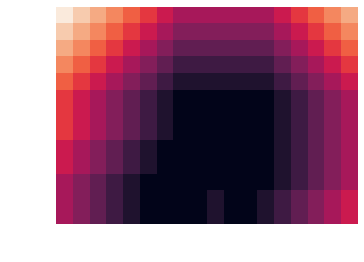

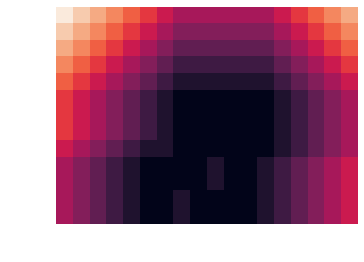

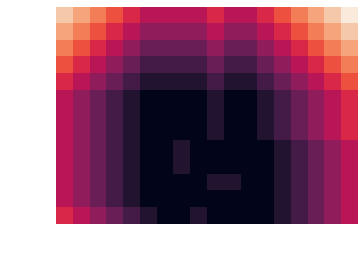

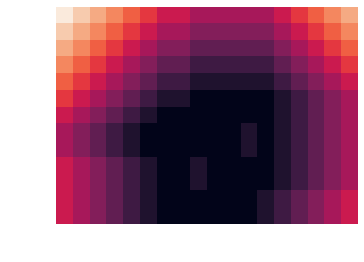

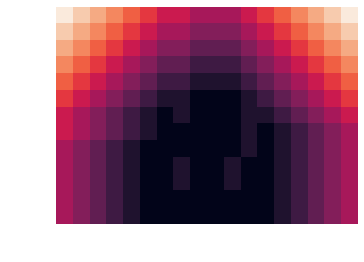

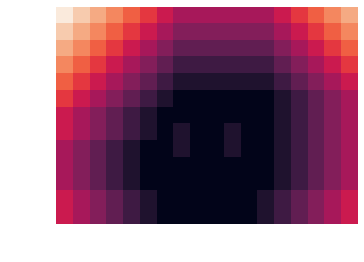

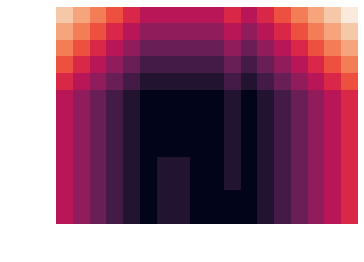

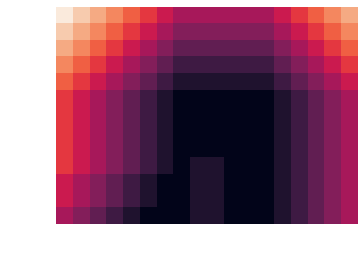

In [40]:
# Calculate square dists

targets = np.sort(df['targetName'].unique()) 
#dists = np.zeros((13,18,8))
dists_squared = {}

for i, target in enumerate(targets):
    # get silhouettes
    silhouette = (1*np.logical_not(targetMaps[target])-1)*(-100)
    silhouette = np.rot90(silhouette)
    #print(silhouette)
    # get city block distances
    silhouette_dists = getBlockDists(silhouette, show_fig=True)
    #dists[:,:,i] = silhouette_dists
    dists_squared[target] = np.square(silhouette_dists)

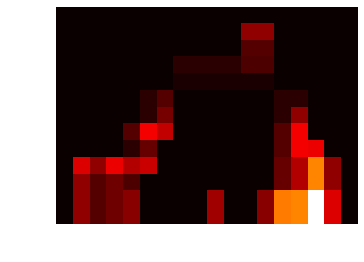

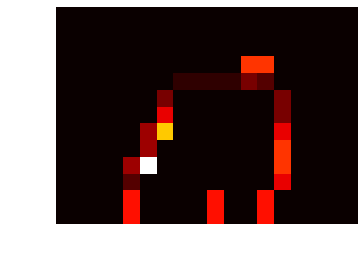

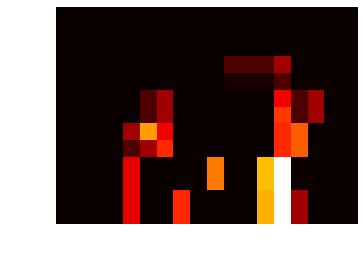

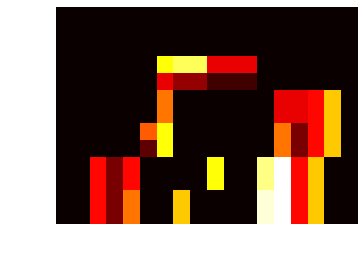

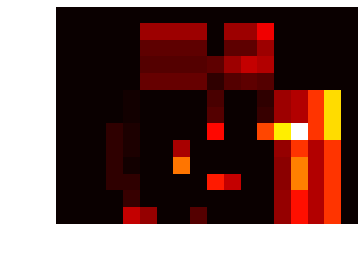

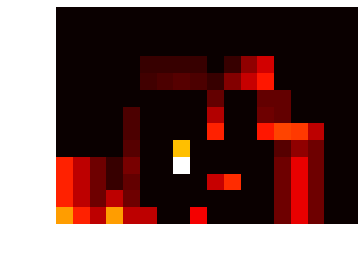

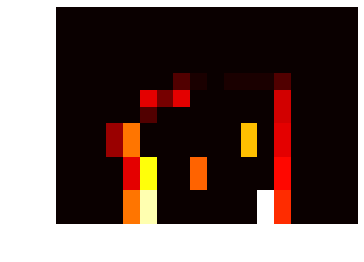

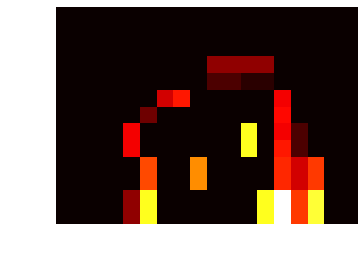

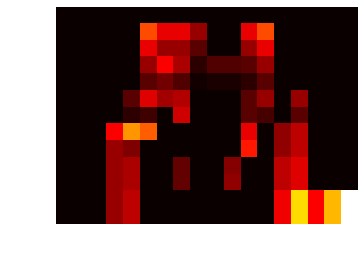

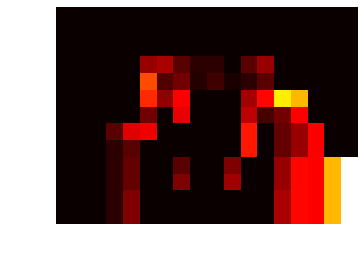

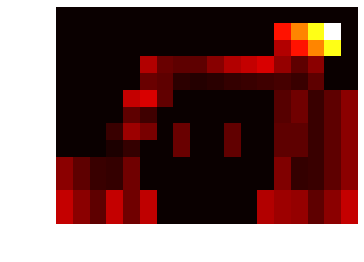

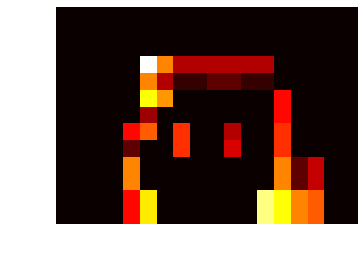

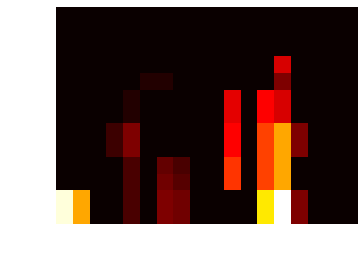

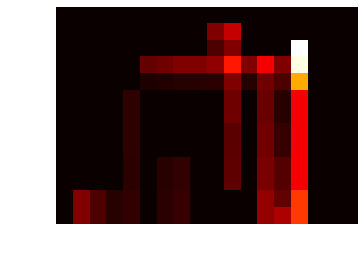

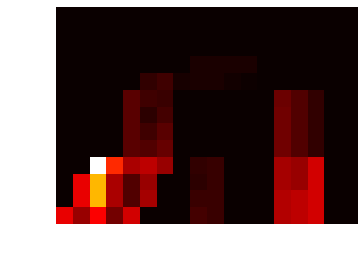

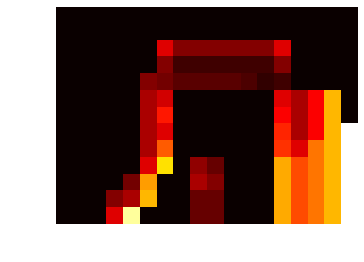

In [41]:
cmap= 'hot'

n = df['gameID'].nunique()
nIters = 1
all_mean_delta_errors = np.zeros(nIters)
random_state_i = 0
for i in range(0,nIters):
    
    all_delta_errors = np.zeros(8)
    
    for j, target in enumerate(targets):
        random_state_i += 1
        pre_random_state = random_state_i
        random_state_i += 1
        post_random_state = random_state_i
        
        pre_reconstructions = df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld']
        pre_sample = pre_reconstructions.sample(n=n, random_state=pre_random_state, replace=True)
        pre_maps = pre_sample.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
        pre_hm_rotated = np.add.reduce(np.array(pre_maps))
        pre_hm = np.rot90(pre_hm_rotated)/n
        pre_errors = np.multiply(pre_hm,dists_squared[target])
        
        post_reconstructions = df[(df.targetName==target) & (df.phase=='post')]['discreteWorld']
        post_sample = post_reconstructions.sample(n=n, random_state=post_random_state,replace=True)
        post_maps = post_sample.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
        post_hm_rotated = np.add.reduce(np.array(post_maps))
        post_hm = np.rot90(post_hm_rotated)/n
        post_errors = np.multiply(post_hm,dists_squared[target])
        
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.imshow(pre_errors, cmap = cmap)
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.imshow(post_errors, cmap = cmap)

In [42]:
# Caclulate cityblock distances
# randomly sample 49 reconstructions, 2*1000 times

# random_reconstructions(target_reconstructions, n=None):
#     if n == None:
#         n = data.shape[0]


n = df['gameID'].nunique()
nIters = 1000
all_mean_delta_errors = np.zeros(nIters)
random_state_i = 0
for i in range(0,nIters):
    
    all_delta_errors = np.zeros(8)
    
    for j, target in enumerate(targets):
        random_state_i += 1
        pre_random_state = random_state_i
        post_random_state = random_state_i
        
        pre_reconstructions = df[(df.targetName==target) & (df.phase=='pre')].sort_values('gameID')['discreteWorld']
        pre_sample = pre_reconstructions.sample(n=n, random_state=pre_random_state, replace=True)
        pre_maps = pre_sample.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
        pre_hm_rotated = np.add.reduce(np.array(pre_maps))
        pre_hm = np.rot90(pre_hm_rotated)/n
        pre_errors = np.multiply(pre_hm,dists_squared[target])
        
        post_reconstructions = df[(df.targetName==target) & (df.phase=='post')].sort_values('gameID')['discreteWorld']
        post_sample = post_reconstructions.sample(n=n, random_state=post_random_state,replace=True)
        post_maps = post_sample.apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
        post_hm_rotated = np.add.reduce(np.array(post_maps))
        post_hm = np.rot90(post_hm_rotated)/n
        post_errors = np.multiply(post_hm,dists_squared[target])
        
#         fig, ax = plt.subplots()
#         ax.axis('off')
#         ax.imshow(pre_errors)
#         fig, ax = plt.subplots()
#         ax.axis('off')
#         ax.imshow(post_errors)
        
        #calculate one number for each matrix of errors
        pre_error = np.sqrt(np.sum(pre_errors))
        post_error = np.sqrt(np.sum(post_errors))
        
        delta_errors = post_error - pre_error
        all_delta_errors[j] = delta_errors
        #subtract pre from post

    #mean over structures
    mean_delta_errors = np.mean(all_delta_errors)
    all_mean_delta_errors[i] = mean_delta_errors
    if(mean_delta_errors>0):
            print('yes')
#calculate CI
all_mean_delta_errors

yes
yes
yes
yes
yes
yes


array([-0.54953205, -0.70122639, -0.65707514, -0.33122653, -0.42182931,
       -0.28821301, -0.68954996, -0.96217823, -0.71780389, -0.55989791,
       -0.72848688, -0.58523833, -0.92132862, -0.31733142, -0.83882212,
       -0.79402968, -0.92454332, -0.85385748, -0.68527262, -0.37567372,
       -0.52632648, -0.54544233, -0.57078712, -0.43366137, -0.54838818,
       -0.34905895, -0.53450442, -0.58433158, -0.60418706, -0.56522424,
       -0.62516891, -0.49226422, -1.00567144, -0.54918763, -0.59403218,
       -0.54014753, -0.69232856, -0.7413347 , -0.16448408, -0.71995586,
       -0.63200236, -0.07110595, -0.7083415 , -0.53087566, -0.73043739,
       -0.35993849, -0.59498655, -0.80598266, -0.97135156, -0.54529352,
       -0.71643565, -0.91398812, -0.61165939, -0.6510036 , -0.61611518,
       -0.72849947, -0.3364239 , -0.5708682 , -0.88391787, -0.50717683,
       -0.85242986, -0.44729271,  0.16054527, -0.64351571, -0.55820417,
       -0.62937969, -0.49078351, -1.44995068, -0.68168115, -0.51

In [43]:
sum(all_mean_delta_errors>0)

6

(array([  3.,   9.,  57., 142., 251., 295., 159.,  66.,  13.,   5.]),
 array([-1.44995068, -1.28759056, -1.12523043, -0.9628703 , -0.80051017,
        -0.63815004, -0.47578992, -0.31342979, -0.15106966,  0.01129047,
         0.1736506 ]),
 <a list of 10 Patch objects>)

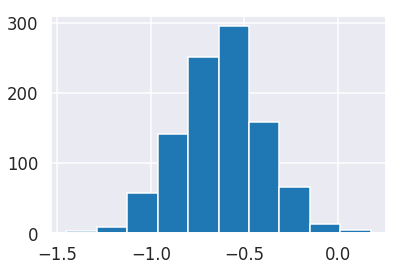

In [44]:
fig, ax = plt.subplots()
plt.hist(all_mean_delta_errors)


In [45]:
np.percentile(all_mean_delta_errors,[2.5,97.5])

array([-1.07617881, -0.20851308])

In [46]:
np.mean(all_mean_delta_errors)

-0.6254550773797435

In [ ]:
pre_reconstructions = df[(df.targetName==target) & (df.phase=='pre')]['discreteWorld']
pre_reconstructions.sample(n=n, random_state=pre_random_state)

In [ ]:
targets = np.sort(df['targetName'].unique()) 
cmap= colors.ListedColormap(['white', 'red'])

target_maps = np.zeros((13,18,8))

for target in targets:
    fig, ax = plt.subplots()
    ax.axis('off')
    silhouette = 1*np.logical_not(targetMaps[target])
    silhouette = np.rot90(silhouette)
    ax.imshow(silhouette)

In [47]:
def getMeanIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.mean(ibis)

def getMedianIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.median(ibis)


def getSDIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.std(ibis)

def getMinIBI(values):
    '''Obtain mean time between block placements'''
    ibis = [] 
    for x, y in zip(values[0::], values[1::]): 
        #print(x,y)
        ibi = y-x
        assert(ibi >= 0)
        ibis.append(y-x)
    return np.min(ibis)

In [48]:
dfi = dfi.drop_duplicates(subset=['gameID','trialNum','blockNum'], keep='last')

dfIBIMean = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMeanIBI).reset_index()
dfIBIMean = dfIBIMean.rename(columns = {'relativePlacementTime':'meanIBI'})
df = pd.merge(df, dfIBIMean, how='left', on=['gameID','trialNum'])

dfIBIMin = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMinIBI).reset_index()
dfIBIMin = dfIBIMin.rename(columns = {'relativePlacementTime':'minIBI'})
df = pd.merge(df, dfIBIMin, how='left', on=['gameID','trialNum'])

thinking_time = dfi[dfi.blockNum==1][['gameID','trialNum','relativePlacementTime']]
thinking_time = thinking_time.rename(columns = {'relativePlacementTime':'thinkingTime'})
df = pd.merge(df, thinking_time, how='left', on=['gameID','trialNum'])

In [49]:
dfIBIMedian = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getMedianIBI).reset_index()
dfIBIMedian = dfIBIMedian.rename(columns = {'relativePlacementTime':'medianIBI'})
df = pd.merge(df, dfIBIMedian, how='left', on=['gameID','trialNum'])


In [50]:
dfIBISD = dfi.sort_values('timeAbsolute').groupby(['gameID','trialNum'])['relativePlacementTime']\
                    .agg(getSDIBI).reset_index()
dfIBISD = dfIBISD.rename(columns = {'relativePlacementTime':'sdIBI'})
df = pd.merge(df, dfIBISD, how='left', on=['gameID','trialNum'])


In [51]:
out_path = 
df.save

,Unnamed: 0,gameID,trialNum,phase,condition,eventType,targetName,repetition,targetID,nullScore,...,meanIBI_x,minIBI_x,thinkingTime_x,medianIBI_x,sdIBI_x,meanIBI_y,minIBI_y,thinkingTime_y,medianIBI_y,sdIBI_y
0,0,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,pre,repeated,trial_end,hand_selected_011,0,5,0.157055,...,5367.750000,1839,16383,5270.0,3266.402943,5367.750000,1839,16383,5270.0,3266.402943
1,1,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,pre,repeated,trial_end,hand_selected_006,0,2,0.155152,...,5382.500000,3023,13315,3909.5,3177.599238,5382.500000,3023,13315,3909.5,3177.599238
2,2,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,2,pre,control,trial_end,hand_selected_005,0,1,0.164948,...,6230.000000,2901,8312,5187.5,3244.700500,6230.000000,2901,8312,5187.5,3244.700500
3,3,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,3,pre,control,trial_end,hand_selected_012,0,6,0.184971,...,4031.100000,1234,8860,3024.0,2370.427955,4031.100000,1234,8860,3024.0,2370.427955
4,4,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,4,pre,repeated,trial_end,hand_selected_004,0,0,0.157055,...,6678.428571,2362,9738,4459.0,4753.956603,6678.428571,2362,9738,4459.0,4753.956603
5,5,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,5,pre,control,trial_end,hand_selected_008,0,3,0.162643,...,7791.750000,2782,8590,5331.5,5836.193981,7791.750000,2782,8590,5331.5,5836.193981
6,6,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,6,pre,repeated,trial_end,hand_selected_009,0,4,0.163683,...,3208.615385,1599,11527,2380.0,1734.628913,3208.615385,1599,11527,2380.0,1734.628913
7,7,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,7,pre,control,trial_end,hand_selected_016,0,7,0.178025,...,3924.000000,1658,9021,2941.0,2466.471001,3924.000000,1658,9021,2941.0,2466.471001
8,8,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,8,repeated,repeated,trial_end,hand_selected_011,1,5,0.157055,...,4571.500000,1928,8629,4310.5,2093.623832,4571.500000,1928,8629,4310.5,2093.623832
9,9,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,9,repeated,repeated,trial_end,hand_selected_009,1,4,0.163683,...,3180.166667,1649,3843,2800.0,1239.527385,3180.166667,1649,3843,2800.0,1239.527385


In [ ]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='meanIBI', 
                  hue='condition',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='medianIBI', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='sdIBI', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
# Inter-block-interval over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='minIBI', 
                  #hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)

In [ ]:
# Thinking time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.lineplot(x='phase_number', 
                  y='thinkingTime', 
                  #legend=False,
                  #kind='point', 
                  data=df)

In [ ]:
# Thinking time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                      y='thinkingTime', 
                      hue='condition',
                      legend=False,
                      #kind='point', 
                      size = 0.3,
                      data=df)

## Block kind analysis including location

We want to see if people are placing the same blocks in the same location
So we should grab their first structure, find the location and type of each block.
And for each (blockKind,location) pair, see if the same exists in the final structure.

These heatmaps give a general sense of the changes in area covered from pre to post phases. However, they are insensitive to the particular strategies-- for example the specific block dimensions- that people used when building these structure. To quantify similarity between construction processes for the same structure, we compared where blocks of specific dimensions were placed.



In [ ]:
def prop_unchanged(a_blocks, b_blocks):
    '''
    Given two dataframes a_blocks and b_blocks of block placements, 
    return the proportion of block placements in a_blocks that are also in b_blocks
    '''
    same = []
    for index, a in a_blocks.iterrows():
        same.append(b_blocks[(b_blocks.blockKind == a['blockKind']) & 
            (b_blocks.x_discrete == a['x_discrete']) & 
            (b_blocks.y_discrete == a['y_discrete'])].shape[0])
    proportion = np.mean(same)
    return proportion

def compare_pre_post(rows):
    pre_blocks = rows[rows.phase=='pre']
    post_blocks = rows[rows.phase=='post']
    return prop_unchanged(pre_blocks,post_blocks)

def compare_reps(rows, rep_a, rep_b):
    pre_blocks = rows[rows.repetition==rep_a]
    post_blocks = rows[rows.repetition==rep_b]
    return prop_unchanged(pre_blocks,post_blocks)

In [ ]:
dfi_prop_unchanged_grouped = dfi[dfi.phase.isin(['pre','post'])].groupby(by=['gameID','targetName']).apply(compare_pre_post)
dfi_prop_unchanged = dfi_prop_unchanged_grouped.reset_index().rename(columns={0: "prop_unchanged"})

In [ ]:
d = pd.merge(df, dfi_prop_unchanged, how='left', on=['gameID','targetName'])
d2 = d[d.phase=='pre']

In [ ]:
plt.hist(x='prop_unchanged',
         data=dfi_prop_unchanged)

In [ ]:
ppt_prop_changed = dfi_prop_unchanged.groupby('gameID').apply(np.mean)
plt.hist(x='prop_unchanged',
         data=ppt_prop_changed)

In [ ]:
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='repeated'])
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='control'])

In [ ]:
d = pd.merge(df, dfi_prop_unchanged, how='left', on=['gameID','targetName'])
d2 = d[d.phase=='pre']
plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.rawF1DiscreteScore>0.8])
#plt.hist(x='prop_unchanged', alpha =0.5, data=d2[d2.condition=='control'])

In [ ]:
dpost = df[df.phase=='post'][['gameID','numBlocks','targetName','rawF1DiscreteScore']]

In [ ]:
dpre = d2[['gameID','numBlocks','targetName','rawF1DiscreteScore','prop_unchanged']]

dprepost = pd.merge(dpre, dpost, on=['gameID','targetName'], how='left', suffixes=('_pre', '_post'))
out_path = os.path.join(csv_dir,'block_silhouette_reuse_{}.csv'.format('Exp2Pilot3'))
dprepost.to_csv(out_path)

In [ ]:
# For each ppt
# 8 pre scores- sort
# 2,2,2,2
# Each has % reuse
# Average those 2
# Each of those quartile goes in a bar

d2_quartile = d2.groupby('gameID').apply(\
    lambda x: x.sort_values('rawF1DiscreteScore').assign(f1_quartile=[1,1,2,2,3,3,4,4]))\
    .reset_index(drop=True)

prop_quartiles = d2_quartile.groupby(['gameID','f1_quartile'])['prop_unchanged'].apply(np.mean).reset_index()
prop_quartiles.loc[prop_quartiles.f1_quartile == 1,'f1_quartile'] = 'lowest'
prop_quartiles.loc[prop_quartiles.f1_quartile == 2, 'f1_quartile'] = 'mid-low'
prop_quartiles.loc[prop_quartiles.f1_quartile == 3, 'f1_quartile'] = 'mid-high'
prop_quartiles.loc[prop_quartiles.f1_quartile == 4, 'f1_quartile'] = 'highest'



saving = False
if saving:
    out_path = os.path.join(csv_dir,'block_silhouette_placement_quartiles_{}.csv'.format('Exp2Pilot3'))
    prop_quartiles.to_csv(out_path)

In [ ]:
fig = plt.figure(figsize=(8,6))
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
sns.set_style('whitegrid', {'legend.frameon':False})
sns.set(rc = {'lines.linewidth':2})
sns.scatterplot(x = 'f1_quartile', 
            y = 'prop_unchanged', 
            #jitter=0, 
            alpha = 0.6, 
            marker = 0,
            s = 60,
            data=prop_quartiles)
sns.pointplot(x='f1_quartile',
              y='prop_unchanged',
              alpha = 0.8,
              markers = [""],
              data = prop_quartiles)


## Between repetition 2 and 3

In [ ]:
rdfi_prop_unchanged_grouped = dfi[(dfi.repetition>=2)].groupby(by=['gameID','targetName']).apply(lambda x: compare_reps(x, 2, 3))
rdfi_prop_unchanged = rdfi_prop_unchanged_grouped.reset_index().rename(columns={0: "prop_unchanged"})

In [ ]:
plt.hist(x='prop_unchanged',
         data=rdfi_prop_unchanged)

In [ ]:
rd = pd.merge(df, rdfi_prop_unchanged, how='left', on=['gameID','targetName'])
rd2 = rd[rd.repetition==2]

In [ ]:
rd2_quartile = rd2.groupby('gameID').apply(\
    lambda x: x.sort_values('rawF1DiscreteScore').assign(f1_quartile=[1,2,3,4]))\
    .reset_index(drop=True)

#prop_quartiles = d2_quartile.groupby(['gameID','f1_quartile'])['prop_unchanged'].apply(np.mean).reset_index()

In [ ]:
fig = plt.figure(figsize=(8,6))
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
sns.set(style="ticks", rc={"lines.linewidth": 1.3})
sns.stripplot('f1_quartile', 'prop_unchanged', jitter=0.05,alpha = 0.5, palette=pal, data=prop_quartiles)
sns.pointplot(x='f1_quartile',
              y='prop_unchanged',
              color='black',
              data = rd2_quartile)

In [ ]:
allstr = df.shape[0]
perfstr = df[df.perfectScore==True].shape[0]
percent = 100*perfstr/allstr
print('all structures: ' + str(allstr))
print('perfect structures: ' + str(perfstr))
print('percent perfect structures: ' + str(percent) + '%')